In this notebook:
* SemEval 2013 Task 13
* Ablation results for the "Word Sense Induction with Neural biLM and Symmetric Patterns" paper


In [2]:
import pandas as pd
import numpy as np
import sys

sys.path.append("..")
from spwsi.semeval_utils import generate_sem_eval_2013
from collections import Counter, defaultdict

titles_pos = {'j': 'ADJ.', 'n': 'NOUN', 'v': 'VERB'}
target_counts = Counter()
targets_by_pos = defaultdict(set)
print('loading dataset instances statistics...')
for _, _, instance_id in generate_sem_eval_2013('../resources/SemEval-2013-Task-13-test-data/'):
    target = instance_id.rsplit('.', 1)[0]
    pos = target.split('.')[-1]
    targets_by_pos[pos].add(target)
    target_counts[target] += 1

to_remove = []
total_instances = 0
for target, count in target_counts.items():
    if count < 50:
        to_remove.append(target)
        print('removing %s for analyisis has it has only %d labeled instances - other targets have around 100' % (
        target, count))
    else:
        total_instances += count
print()
print('After removing instances:')
total_targets = 0
for pos, targets_set in targets_by_pos.items():
    targets_set -= set(to_remove)
    total_targets += len(targets_set)
    print('%d targets with part of speech %s' % (len(targets_set), titles_pos[pos]))
print('in total, %d instances from %d targets' % (total_instances, total_targets))
print()
print('Note: this pruning is done only for the part of speech break-down exploration below and isn\'t done during WSI')


loading dataset instances statistics...
removing trace.n for analyisis has it has only 37 labeld instances - other targets have around 100
removing book.v for analyisis has it has only 22 labeld instances - other targets have around 100

After removing instances:
19 targets with part of speech VERB
19 targets with part of speech NOUN
10 targets with part of speech ADJ.
in total, 4605 instances from 48 targets

Note: this pruning is done only for the part of speech break-down exploration below and isn't done during WSI


In [3]:
from collections import defaultdict

target_senses = defaultdict(set)
with open('../resources/SemEval-2013-Task-13-test-data/keys/gold/all.key', 'r') as fin:
    for line in fin:
        target, inst, senses = line.strip().split(' ', 2)
        if target in to_remove:
            continue
        senses = [x.split('/')[0] for x in senses.split()]
        target_senses[target].update(senses)
rows = []
for target, senses in target_senses.items():
    pos = target.split('.')[-1]
    rows.append((pos, len(senses)))
dfs = pd.DataFrame(rows, columns=['pos', 'count_senses'])
print('Number of senses per target, by part of speech:')
print()
print('ALL   mean:%.2f std:%.2f' % (dfs.count_senses.mean(), dfs.count_senses.std()))
titles_pos = {'j': 'ADJ.', 'n': 'NOUN', 'v': 'VERB'}
print()
for pos, title in titles_pos.items():
    print('%s  mean:%.2f std:%.2f' % (
        title, dfs[dfs.pos == pos].count_senses.mean(), dfs[dfs.pos == pos].count_senses.std()))


Number of senses per target, by part of speech:

ALL   mean:6.94 std:2.71

ADJ.  mean:5.90 std:1.37
NOUN  mean:7.32 std:2.21
VERB  mean:7.11 std:3.54


## effect of number of clusters on task score

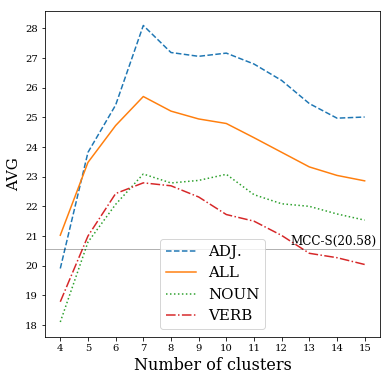

In [69]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Serif'
dfnc=pd.read_csv('n_clusters.data.csv.gz')
titles_pos={'all':'ALL','j':'ADJ.','n':'NOUN','v':'VERB'}
dfnc['pos']=dfnc.target.apply(lambda x:'ALL' if x=='all' else titles_pos[x.split('.')[1]])
dfnc=dfnc.sort_values('pos')
grouped=dfnc.groupby(['n_clusters','pos']).mean().unstack().AVG *100
ax = grouped.plot(figsize=(6,6),style=['--','-',':','-.'])
# ax.set_title('AVG by number of clusters',fontsize=20)
ax.set_xlabel('Number of clusters',fontsize=16)
ax.set_ylabel('AVG',fontsize=15)
plt.xticks(np.arange(4, 16))
plt.yticks(np.arange(18, 29))
ax.legend(grouped.columns,fontsize=15);
ax.axhline(20.58,color="black",alpha=0.3,linewidth=1)
ax.text(12.3,20.7,"MCC-S(20.58)",size=12)
plt.show()

## Ablation, broken down by part of speech

Ablation results:

     removed  AVG_mean  AVG_std  FNMI_mean  FNMI_std  FBC_mean  FBC_std
0    vanilla     25.43     0.48      11.26      0.43     57.49     0.23
1         sp     23.36     0.48       9.83      0.40     55.51     0.34
2        lem     22.39     0.52       9.54      0.43     52.61     0.25
3      tfidf     23.32     0.65       9.19      0.52     59.21     0.27
4     sp_lem     23.08     0.56       9.59      0.43     55.58     0.44
5  all_flags     23.24     0.60       9.49      0.50     56.92     0.34


Ablation by pos:

      removed pos  AVG_mean  AVG_std
0     vanilla   j     27.50     1.60
1          sp   j     24.30     1.19
2         lem   j     25.68     1.49
3       tfidf   j     24.36     1.85
4      sp_lem   j     24.08     1.19
5   all_flags   j     25.03     1.16
6     vanilla   n     22.88     0.82
7          sp   n     22.59     0.70
8         lem   n     22.33     0.62
9       tfidf   n     19.54     1.16
10     sp_lem   n     22.37     0.81
11  all_flags

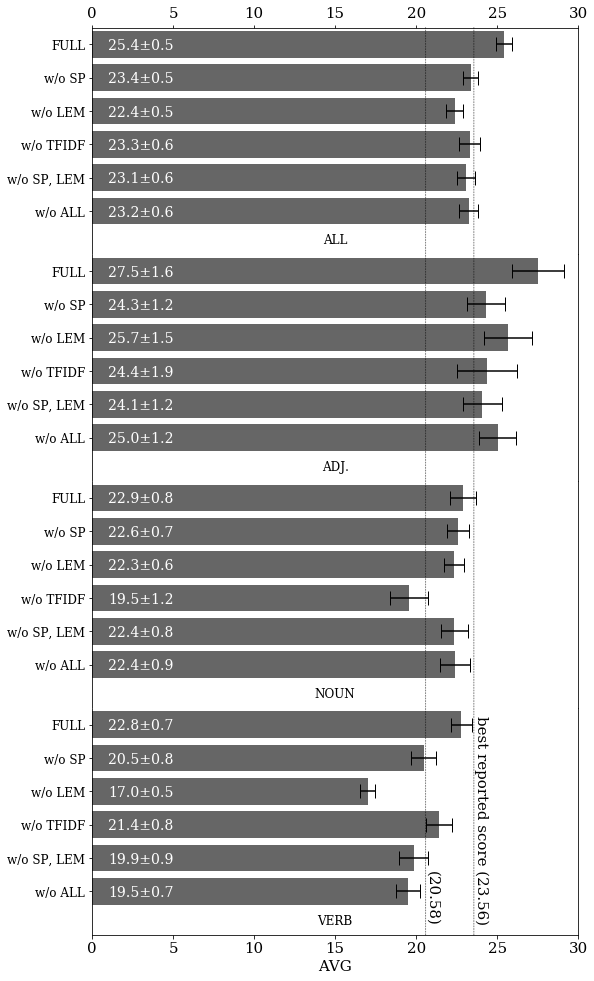

In [4]:
import matplotlib.patheffects as PathEffects
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt

# ablations
dfa = pd.read_csv('ablation.data.csv.gz').query('target == "all"')[
    ['AVG', 'FBC', 'FNMI', 'disable_lemmatization', 'disable_symmetric_patterns', 'disable_tfidf']]
all_settings = dict(
    vanilla='disable_lemmatization == False and disable_symmetric_patterns == False and disable_tfidf == False',
    sp='disable_lemmatization == False and disable_symmetric_patterns == True and disable_tfidf == False',
    lem='disable_lemmatization == True and disable_symmetric_patterns == False and disable_tfidf == False',
    tfidf='disable_lemmatization == False and disable_symmetric_patterns == False and disable_tfidf == True',
    sp_lem='disable_lemmatization == True and disable_symmetric_patterns == True and disable_tfidf == False',
    all_flags='disable_lemmatization == True and disable_symmetric_patterns == True and disable_tfidf == True',
    )
res = []
for settings, query in all_settings.items():
    avgs = dfa.query(query)['AVG'] * 100
    fnmis = dfa.query(query)['FNMI'] * 100
    fbcs = dfa.query(query)['FBC'] * 100
    res.append((settings, avgs.mean(), avgs.std(), fnmis.mean(), fnmis.std(), fbcs.mean(), fbcs.std()))
ablations = pd.DataFrame(res,
                         columns=['removed', 'AVG_mean', 'AVG_std', 'FNMI_mean', 'FNMI_std', 'FBC_mean', 'FBC_std'])
print('Ablation results:')
print()
print(ablations.round(2))
print()
print()
# ablations by pos
dfa = pd.read_csv('ablation.data.csv.gz').query('target != "all"')[
    ['run_name', 'AVG', 'target', 'disable_lemmatization', 'disable_symmetric_patterns', 'disable_tfidf']]
dfa['pos'] = dfa.target.apply(lambda x: 'all' if x == 'all' else x.split('.')[1])
dfa = dfa[~dfa['target'].isin(to_remove)]
# to make it comparable to all which is a mean, we first mean across run by POS
dfa = dfa.groupby(['run_name', 'pos']).mean().reset_index()
res = []
for pos in dfa['pos'].unique():
    for settings, query in all_settings.items():
        avgs = dfa[dfa.pos == pos].query(query)['AVG'] * 100
        res.append((settings, pos, avgs.mean(), avgs.std()))
ablations_pos = pd.DataFrame(res, columns=['removed', 'pos', 'AVG_mean', 'AVG_std'])
print('Ablation by pos:')
print()
print(ablations_pos.round(2))
print()
print()
ablations_full = pd.concat([ablations, ablations_pos], sort=True).fillna('all')

f, axs = plt.subplots(4, 1, figsize=(7.5, 15), sharey=True)

titles_pos = {'all': 'ALL', 'j': 'ADJ.', 'n': 'NOUN', 'v': 'VERB'}
labels = {'vanilla': 'FULL', 'sp': 'w/o SP', 'lem': 'w/o LEM', 'tfidf': 'w/o TFIDF', 'sp_lem': 'w/o SP, LEM',
          'all_flags': 'w/o ALL'}
position = {'vanilla': 5, 'sp': 4, 'lem': 3, 'tfidf': 2, 'sp_lem': 1, 'all_flags': 0}
pallete = {'vanilla': '#444444', 'sp': '#555555', 'lem': '#666666', 'tfidf': '#777777', 'sp_lem': '#888888',
           'all_flags': '#999999'}
font = {'fontname': 'DejaVu Serif', 'size': 10}
for idx, (pos, ax) in enumerate(zip(['all', 'j', 'n', 'v'], axs)):

    data = ablations_full[ablations_full.pos == pos]
    y_laybles = [labels[x] for x in data.removed.values]
    colors = [pallete[x] for x in data.removed.values]
    vals = data['AVG_mean'].values
    stds = data['AVG_std'].values
    y_pos = [position[x] for x in data.removed.values]

    ax.barh(y_pos, vals, xerr=stds, align='center', color=['#666666'],
            ecolor='black', capsize=7)

    ax.spines['bottom'].set_visible(idx == 3)
    ax.spines['top'].set_visible(idx == 0)

    ax.set_title(titles_pos[pos], y=0.02, size=12)
    ax.set_yticks(y_pos)
    for x in ax.get_xticklabels():
        x.set_size(15)
    ax.set_xlim(0, 30)
    ax.set_ylim(-1.3, 5.5)
    ax.set_yticklabels(y_laybles, size=12)

    for i in range(6):
        ax.text(1, i - 0.15, "%.1f±%.1f" % (vals[5 - i], stds[5 - i]), color="white", size=14)

axs[0].xaxis.tick_top()
for x in axs[0].get_xticklabels():
    x.set_size(15)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[-1].set_xlabel('AVG', fontsize=15)

con = ConnectionPatch(xyA=(23.56, -1.3), xyB=(23.56, 5.5), coordsA="data", coordsB="data", alpha=0.5,
                      axesA=axs[-1], axesB=axs[0], color="k", ls=':', lw=1)
axs[-1].add_artist(con)

axs[-1].text(23.56, -1, 'best reported score (23.56)', rotation=270, size=15, verticalalignment='bottom')

con = ConnectionPatch(xyA=(20.58, -1.3), xyB=(20.58, 5.5), coordsA="data", coordsB="data", alpha=0.5,
                      axesA=axs[-1], axesB=axs[0], color="k", ls=':', lw=1)
axs[-1].add_artist(con)

txt = axs[-1].text(20.58, -1, '(20.58)', rotation=270, size=15, verticalalignment='bottom')
# txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='#333333')])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=0.95, hspace=0,
                    wspace=0)
plt.show()


## why symmetric patterns without lemmatization is failing on verbs

in the code that follows we show why using symmteric patterns without lemmatization is a bad idea.
since symmetric patterns substitutes tend to agree on tense with the disambiguated word, different tensed word, even with the same sense,
have different substitutes - matching tense with the disambiguated word.

we predict subsitute represntatives as done in the paper, cluster them, and show the clustering created uni-tensed groups, disregarding actual sense

we do this by fitting a linear regression model on the clusters created and looking at the LR coeficents.
Note that the features aren't the best substitutes for the target but good indicators for separtions among the senses of the given target

In [5]:
print('verb targets:\n'+' '.join(targets_by_pos['v']))

verb targets:
help.v become.v live.v meet.v appear.v find.v add.v serve.v transfer.v strike.v wait.v lose.v read.v dismiss.v trace.v write.v suggest.v win.v ask.v


In [6]:
target_target = 'suggest.v'

In [7]:
# this essentially recreates our method, induce clusters for target_target and train a logistic regression model to 
# find most influential featrues(words) for the given clusters

from spwsi.spwsi import DEFAULT_PARAMS
from spwsi.semeval_utils import generate_sem_eval_2013

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from collections import Counter
from sklearn import linear_model
from spwsi.bilm_elmo import BilmElmo

# load dataset for target_target
target_target_insts = dict()
for tokens, target_idx, inst_id in generate_sem_eval_2013('../resources/SemEval-2013-Task-13-test-data'):
    target = inst_id.rsplit('.', 1)[0]
    if target == target_target:
        target_target_insts[inst_id] = (tokens, target_idx)


# create an LM for predicting substitutes
CUDA_DEVICE = 0
elmo_vocab_path = '../resources/vocab-2016-09-10.txt'
BilmElmo.create_lemmatized_vocabulary_if_needed(elmo_vocab_path)
elmo_as_lm = BilmElmo(CUDA_DEVICE, '../resources/elmo_2x4096_512_2048cnn_2xhighway_softmax_weights.hdf5',
                      elmo_vocab_path,
                      batch_size=DEFAULT_PARAMS['lm_batch_size'],
                      cutoff_elmo_vocab=DEFAULT_PARAMS['cutoff_lm_vocab'])

# we'll repeat once with lemmatization and once without
disable_tfidf = False
disable_symmetric_patterns = False
for disable_lemmatization in True, False:
    print('disable_lemmatization', disable_lemmatization)

    # draw representatives as done in the paper
    n_clusters = DEFAULT_PARAMS['n_clusters']
    inst_ids_to_representatives_sp_no_lem = elmo_as_lm.predict_sent_substitute_representatives(
        target_target_insts, DEFAULT_PARAMS['n_represent'], DEFAULT_PARAMS['n_samples_side'],
        disable_symmetric_patterns, disable_lemmatization,
        DEFAULT_PARAMS['prediction_cutoff'])

    inst_ids_ordered = list(inst_ids_to_representatives_sp_no_lem.keys())
    lemma = inst_ids_ordered[0].rsplit('.', 1)[0]
    representatives = [y for x in inst_ids_ordered for y in inst_ids_to_representatives_sp_no_lem[x]]
    n_represent = len(representatives) // len(inst_ids_ordered)
    to_pipeline = [DictVectorizer()]
    if not disable_tfidf:
        to_pipeline.append(TfidfTransformer())
    data_transformer = make_pipeline(*to_pipeline)
    transformed = data_transformer.fit_transform(representatives).todense()
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', affinity='cosine')
    clustering.fit(transformed)
    senses = {}
    for i, inst_id in enumerate(inst_ids_ordered):
        inst_id_clusters = Counter(clustering.labels_[i * n_represent:
                                                      (i + 1) * n_represent])
        senses[inst_id] = inst_id_clusters

    # we fit a logistic regression to find indicative words for that sense
    clusters_centers = []
    for cluster_idx in set(clustering.labels_):
        clusters_centers.append(
            np.array(np.mean(transformed[np.where(clustering.labels_ == cluster_idx)], 0)).reshape(-1))
    logistic = linear_model.LogisticRegression(fit_intercept=False)
    logistic.fit(clusters_centers, range(n_clusters))

    # we print the results and see senses are grouped by tense when lemmatization isn't done but symmetric patterns is
    for cluster_idx in range(n_clusters):
        print('cluster', cluster_idx)
        for inst_id, senses_inst in senses.items():
            best_sense, _ = senses_inst.most_common()[0]
            if best_sense == cluster_idx:
                tokens = target_target_insts[inst_id][0].copy()
                idx_int_tokens = target_target_insts[inst_id][1]
                word = tokens[idx_int_tokens]
                tokens[idx_int_tokens] = '***' + word + '***'
                print(' '.join(tokens))
                break
        best_features = np.argsort(logistic.coef_[cluster_idx])[-5:]
        best_words = [to_pipeline[0].feature_names_[x] for x in best_features]
        print(best_words)
        print()
    print()
    print()


/home/nlp/asafam/miniconda2/envs/py36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


disable_lemmatization True
cluster 0
The NYT cites law enforcement officials saying that the tape supports their account that the canisters bounced harmlessly off the bunker 's roof and hence could not have started the subsequent lethal fire , and also points out that nobody in law enforcement , including Reno , has ***suggested*** that the tear - gas devices contributed to the fire .
['applauded', 'talked', 'pointed', 'discussed', 'expressed']

cluster 1
This is n't to ***suggest*** that there 's any obligation -- as you say about the mental health profession -- to intervene against people who hold racist beliefs .
['recommend', 'reflect', 'promote', 'try', 'explain']

cluster 2
Now Steele claims that Willey did n't mention anything at all about a pass , wanted or not -- Steele has signed an affidavit ( Version # 3 ) claiming that Willey " never said anything to ***suggest*** that President Clinton made sexual advances toward her . "
['schools', 'no', 'airports', 'did', 'didn']

clust

### Statistics on how tense correlates to sense
We calculate the mean normalized mutual information(NMI) between tense and sense.

Values are between 0 and 1 where 1 means perfect correlation. we expect some corrlation between them as seen in the gold label mean NMI

In [5]:
from collections import defaultdict
from sklearn.metrics.cluster import normalized_mutual_info_score

# find tense in dataset instances:
import spacy

nlp = nlp = spacy.load("en", disable=['ner'])
inst_id_to_tense = {}
for tokens, target_idx, inst_id in generate_sem_eval_2013('../resources/SemEval-2013-Task-13-test-data'):
    lemma_pos = inst_id.rsplit('.', 1)[0]
    pos = lemma_pos.split('.')[-1]
    if pos != 'v':
        # we only need verbs
        continue
    doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    nlp.tagger(doc)
    inst_id_to_tense[inst_id] = doc[target_idx].tag_

all_tenses_ordered = list(set(inst_id_to_tense.values()))


def get_semeval_key_best_senses(filepath, filterset):
    ret = defaultdict(dict)
    with open(filepath) as fin:
        for line in fin:
            target, inst_id, senses = line.strip().split(maxsplit=2)
            if not inst_id in filterset:
                continue
            senses = [x.split('/') for x in senses.split()]
            senses = sorted(senses, key=lambda x: int(x[1]))
            best_sense = senses[-1][0]
            ret[target][inst_id] = best_sense
    return ret


for setting_name, key_path in [('w/ symmetric patterns w/ lemmatization', 'sp_lem.key'),
                               ('w/ symmetric patterns w/o lemmatization', 'sp_no_lem.key'),
                               ('w/o symmetric patterns w/o lemmatization', 'no_sp_no_lem.key'),
                               ('w/o tfidf', 'no_tfidf.key'),
                               ('w/o all', 'no_all.key'),
                               ('w/o sp', 'no_sp.key'),
                               ('gold labels', '../resources/SemEval-2013-Task-13-test-data/keys/gold/verbs.key')]:
    mis = []
    semeval_key = get_semeval_key_best_senses(key_path, inst_id_to_tense)
    for target, di in semeval_key.items():
        order_of_insts = list(di.keys())
        order_of_senses = list(set(di.values()))
        X = [order_of_senses.index(di[x]) for x in order_of_insts]
        Y = [all_tenses_ordered.index(inst_id_to_tense[x]) for x in order_of_insts]
        mis.append(normalized_mutual_info_score(X, Y))
    print('%s: mean ± STD NMI: %.2f ± %.2f ' % (setting_name, np.mean(mis), np.std(mis)))


w/ symmetric patterns w/ lemmatization: mean ± STD NMI: 0.22 ± 0.12 
w/ symmetric patterns w/o lemmatization: mean ± STD NMI: 0.67 ± 0.12 
w/o symmetric patterns w/o lemmatization: mean ± STD NMI: 0.26 ± 0.09 
w/o tfidf: mean ± STD NMI: 0.18 ± 0.07 
w/o all: mean ± STD NMI: 0.24 ± 0.08 
w/o sp: mean ± STD NMI: 0.19 ± 0.08 
gold labels: mean ± STD NMI: 0.15 ± 0.07 
